# Don't use Forsyth-Edwards Notation to play chess with LLMs

Anton Antonov    
Raku Advent Calendar 2024   
November 2024   

-----

## Introduction

This notebook (or computational document) discusses several topics:

- Making nice plots of chess positions 
    - Using Raku's ["JavaScript::D3"](https://raku.land/zef:antononcube/JavaScript::D3), [AAp1]
- Staging and interactively using an Large Language Model (LLM) persona for playing chess
- Using LLM-vision over chess position images
- Deficiencies of LLMs playing chess via [Forsyth-Edwards Notion (FEN)](https://en.wikipedia.org/wiki/Forsyth–Edwards_Notation), [Ch1]
    - A conjecture is formed using a few experimental results 
    - That conjecture is "proved" (i.e. explained) by a reasoning LLM ([ChatGPT's "o1-preview"](https://platform.openai.com/docs/models#o1), [OI1])

The notebooks showcases utilization of [Raku's LLM-related functionalities](https://raku.land/?q=LLM): [chatbooks](), [LLM-functions](), and [LLM-prompts]().


In other words, the notebook (document) has:
- Two *Raku know-how* topics: plotting chess positions and LLM persona making and interaction 
- A *general know-why* topic: reasons for LLM-deficiencies while using FEN

**Remark:** Playing chess (really) well with LLMs is not the focus of this notebook (document.)

### TL;DR

- The making of nice and tunable chess position (JavaScript) plots is facilitated by Raku.
    - Marveling at the chess position plots is encouraged.
- The main message of the notebook/document is the section "Possible explanations".
    - Asking LLMs to play chess via FEN is counter-productive.
    - FEN "compresses" field data and LLMs are not good at predicting those kind of sequential compressions.

### On chess playing

There are plenty of (research) articles, posts, software packages, or coding projects about *LLMs-and-chess*. (For example, see [DM1, NC1, NCp1, MLp1].)

At least half a dozen of those articles and posts proclaim much better results than the examples given below.

Those articles, posts, or projects, though, use:

- Well known chess games
- Notations other than FEN 
    - [Portable Game Notation (PGN)](https://en.wikipedia.org/wiki/Portable_Game_Notation)
    - [Algebraic Notation (AN)](https://en.wikipedia.org/wiki/Algebraic_notation_(chess))
    - Textual/ASCII chess position representation
- Connections to 3rd party programs

------

## LLM persona -- ***ChessMaster***

Here is the prompt of an LLM persona for playing chess:

In [16]:
#% chat cm prompt, model=gpt-4o, max-tokens=4096, temperature=0.25
You are a ChessMaster engaged in a text-based chess game. You play the opponent, usually with the black chess pieces and pawns. 
The game should be easy to follow and adhere to standard chess rules. 

Here is how you behave:

- Use Forsyth-Edwards Notation (FEN) strings to communicate the state of the gameplay.

- Ensure you play by standard chess rules.

- Ensure the game interprets and executes these moves correctly.

- Allow the player to input using: 
    1. Algebraic Notation (AN) input, for example, "e2 to e4" to move a pawn
    2. Descriptive input, like, "bishop from a3 to f8" 

- When the user gives you AN string you respond with three strings: 
    1. FEN position after user's AN input is played
    2. Your move given as AN string
    3. FEN position after your AN move is played

- If asked provide clear feedback to the player after each move, including the move itself.
    - For example, "You moved: e2 to e4" and "Opponent moved: e7 to e5".

- If you take a figure of the user make sure say that in your responses. 

- If asked provide player guidance
    - Include in-game guidance resources or instructions that explain chess rules, move input, and special conditions like check and checkmate.
    
- Proclaim when the user gives you AN move that is wrong, noncompliant with the standard chess rules.

- When the user asks you to start a game without specifying a FEN string:
    - You give the standard initial position as start.
    
- You play the black opponent, the user plays the white, except if the user says that he plays the black side.

Chat object created with ID : cm.

A few observations on the prompt above:

- The prompt is carefully crafted.
    - Other research efforts often use much shorter prompts like "You chess master."
- FEN is explicitly postulated as the way to communicate the "game field."
- Both AN and plain English are "allowed" as user input.

**Remark:** Below the LLM persona is referred to as "ChessMaster" or "CM".

--------

## Chess position plotting setup

This section shows the setup for plotting chess positions *while using a [Raku Chatbook](https://raku.land/zef:antononcube/Jupyter::Chatbook)*, [AAp].

Packages:

In [6]:
use Data::Importers;
use FEN::Grammar;
use JavaScript::D3;
use JavaScript::D3::Chess; # Needed only to show tuning parameters 


Priming for JavaScript plots code rendering:

In [7]:
%% javascript
require.config({
     paths: {
     d3: 'https://d3js.org/d3.v7.min'
}});

require(['d3'], function(d3) {
     console.log(d3);
});

Styling options, (default and "greens"):

In [8]:
# Default style
my %opts =
    color-palette => 'YlOrBr',
    black-square-value => 0.55,
    white-square-value => 0.25,
    opacity => 0.65,
    whites-fill-color => 'Ivory',
    whites-stroke-color => 'DimGray',
    tick-labels-color => 'Grey',
    background => 'none', # '#1F1F1F'
    title-color => 'Gray',
    width => 400;

# chess.com style
my %opts-greens =
    color-palette => 'Greens',
    black-square-value => 0.8,
    white-square-value => 0.2,
    opacity => 0.7,
    whites-fill-color => 'White',
    whites-stroke-color => 'DarkSlateGray',
    blacks-fill-color => '#1F1F1F',
    blacks-stroke-color => 'Black',
    tick-labels-color => 'Grey',
    background => 'none', #'#1F1F1F'
    title-color => 'Gray',
    width => 400;

(%opts.elems, %opts-greens.elems)

(10 12)

Examples of an initial chess position plot (without using a FEN string) and a blank chessboard:

In [9]:
#%js
js-d3-chessboard(|%opts, title => 'Initial position') ~
js-d3-chessboard('8/8/8/8/8/8/8/8',|%opts-greens, title => 'Empty chessboard')

Using a different plotting style with non-trivial FEN strings:

In [10]:
#%js
[
    "rnbqkB1r/pppp1ppp/5n2/4p3/8/1P6/P1PPPPPP/RN1QKBNR b KQkq - 0 3",
    "4kb1r/p4ppp/4q3/8/8/1B6/PPP2PPP/2KR4"
] ==>
js-d3-chessboard(
    tick-labels-color => 'silver', 
    black-square-value => 0.5, 
    background => '#282828',
    opacity => 0.75,
    margins => 15,
    width => 350
)

In "JavaScript:D3":

- Input chess position strings are processed with "FEN::Grammar"
- Almost any element of chess position plotting is tunable
- Chess position plotting is based on heatmap plotting
    - Hence, arguments of `js-d3-heatmap-plot` can be used.

Here are the explicit tunable parameters:

In [11]:
.say for &JavaScript::D3::Chess::Chessboard.candidates.map({ $_.signature.params».name }).flat.unique.grep({ $_.Str ∉ <@data $data %args $div-id>}).sort

$background
$black-square-value
$blacks-fill-color
$blacks-font-family
$blacks-stroke-color
$color-palette
$format
$height
$margins
$opacity
$tick-labels-color
$title
$white-square-value
$whites-fill-color
$whites-font-family
$whites-stroke-color
$width


-----

## Chess notation sub-strings extraction

In this section are given several methods for extracting FEN strings from (free) text strings. (I.e. chess LLM outputs.)

A function to check whether is a FEN string or not:

In [12]:
my sub is-fen-string(Str:D $txt) {
    my $match = FEN::Grammar.parse($txt);
    return $match.defined;
}

&is-fen-string

Here is a way to use that predicate function:

In [13]:
my sub fen-specs-by-predicate(Str:D $txt) {
   
  # First the faster check 
  my @res = do with $txt.match(/ $<delim>=('`'|\v) $<fen>=(<-[\v`]>+) $<delim> /, :g) {
     $/.values.map({ $_<fen>.Str.trim => &is-fen-string($_<fen>.Str.trim)});
  }
  @res .= grep({ $_.value });

  return @res».key if @res; 

  # Slow(er) check
  my @res2 = do with $txt.match(/ $<fen>=(.*) <?{ is-fen-string($<fen>.Str) }> /, :g) {
     $/.values.map({ $_<fen>.Str.trim });
  } else { Nil }

  return @res2; 
}

&fen-specs-by-predicate

**Remark:** The functions `is-fen-string` and `fen-specs-by-predicate` are useful if 3rd party chess notation packages are used. (Not necessarily Raku-grammar based.)

Here is a fast and simple to use a Raku grammar to extract FEN strings:

In [14]:
my sub fen-specs(Str:D $txt) {
    return do with $txt.match( /<FEN::Grammar::TOP>/, :g) { $/».Str };
}

&fen-specs

Here are examples using both approaches:

In [15]:
my $txt = q:to/END/;
You moved: b2 to b3

FEN after your move: `rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1`

Now, it's my turn. I'll play:

Opponent moved: e7 to e5

FEN after my move: `rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2`

Your move!
END

say "fen-specs-by-predicate : ", fen-specs-by-predicate($txt).raku;
say "fen-specs              : ", fen-specs($txt).raku;

fen-specs-by-predicate : ["rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1", "rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2"]
fen-specs              : ("rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1", "rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2")


-----

## Example play

This section has an example play (again within a [Raku chatbook](https://raku.land/zef:antononcube/Jupyter::Chatbook), [AAp2].)

Starting a game:

In [17]:
#% chat cm > markdown
Let us start a new game.

Great! Let's start a new game. Here's the standard initial position:

FEN: `rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1`

It's your move. You can use Algebraic Notation (AN) or descriptive input to make your move.

Plotting the FEN strings from the LLM output:

In [18]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

User first move:

In [19]:
#% chat cm > markdown
b2 to b3

You moved: b2 to b3

FEN after your move: `rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1`

Now it's my turn.

Opponent moved: e7 to e5

FEN after my move: `rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBNR w KQkq e6 0 2`

Your move!

Plotting the FEN strings from the LLM output:

In [20]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

Another user move:

In [21]:
#% chat cm > markdown
Bishop from c1 to a3

You moved: Bishop from c1 to a3

FEN after your move: `rnbqkbnr/pppp1ppp/8/4p3/B7/1P6/P1PPPPPP/RN1QKBNR b KQkq - 1 2`

Now it's my turn.

Opponent moved: d7 to d6

FEN after my move: `rnbqkbnr/ppp2ppp/3p4/4p3/B7/1P6/P1PPPPPP/RN1QKBNR w KQkq - 0 3`

Your move!

User move and ChessMaster move:

In [22]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

The chess positions clearly show the wrong LLM move (or FEN string). Trying to fix it:

In [23]:
#% chat cm
No, your move is wrong -- I have two white bishops now.

Apologies for the oversight. Let's correct that.

Your move: Bishop from c1 to a3

FEN after your move: `rnbqkbnr/pppp1ppp/8/4p3/B7/1P6/P1PPPPPP/RN1QKBNR b KQkq - 1 2`

Now it's my turn.

Opponent moved: Ng8 to f6

FEN after my move: `rnbqkb1r/pppp1ppp/5n2/4p3/B7/1P6/P1PPPPPP/RN1QKBNR w KQkq - 2 3`

Your move!

Well the LLM fix preserved the same wrong moves.

In [24]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

### Alternative development

Another user move -- taking the pawn at `d6`:

In [ ]:
#% chat cm > markdown
bishop from a3 to d6

The chess positions clearly see the wrong LLM moves (or FEN strings):

In [ ]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

Trying to fix it:

In [ ]:
#% chat cm > markdown
Well, you removed the bishop which took the pawn on `d6` and you kept on `d6` that pawn of yours.

The FEN string of the "correction" is the same as above: 

In [ ]:
#%js
js-d3-chessboard(fen-specs(cbpaste), |%opts)

----

## Chess position recognition

It is interesting to review the abilities of the vision (or "omni") LLM models to recognize chess positions and produce the (correct) corresponding notation strings.

**Remark:** (Some of) the LLM-vision models explicitly state that they are not good at recognizing chess positions.
(For example, see [OpenAI's "Vision/Limitations"](https://platform.openai.com/docs/guides/vision#limitations).)

Consider the following image from [this StackExchange post](https://puzzling.stackexchange.com/q/125524):

In [25]:
#%js
my $url = 'https://i.sstatic.net/uKnenm.png';
js-d3-image-display($url)

Here image's corresponding Base64 string is obtained and rendered:

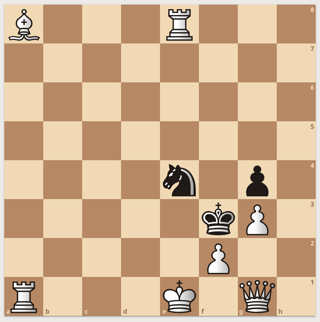

In [26]:
#%markdown
my $imgBase64 = data-import($url, format => 'md-image');

**Remark:** The Raku chatbook visualizations via JavaScript and URLs are faster.

Here is an LLM vision application (using image's URL):

In [27]:
#% markdown
my $chessDescr = llm-vision-synthesize('Describe the following image:', $url);

The image shows a chess position on an 8x8 board. The pieces are arranged as follows:

- White pieces:
  - Bishop on a8
  - Rook on e8
  - Rook on a1
  - King on e1
  - Queen on g1
  - Pawn on f2
  - Pawn on g3

- Black pieces:
  - Knight on e4
  - King on f3
  - Pawn on g4

It's White's turn to move.

**Remark:** The positions of both the white and black figures are recognized correctly.

Get Raku code instead of a textual description:

In [28]:
my $chessSpec = llm-synthesize([
    'Convert the following chess position description into a JSON array of dictionaries.',
    'Conversion examples:',
    '- "Black rook on e8" converts to `{x: "e", y: "8", z: "R"}`',
    '- "White bishop on a4" converts to `{x: "a", y: "4", z: "b"}`',
    'The key "z" has small letters for the blacks, and capital letters for the whites.',
    'DESCRIPTION:',
    $chessDescr,
    llm-prompt('NothingElse')('JSON')
    ], 
    e => llm-configuration('chatgpt', model => 'gpt-4o', temperature => 0.4),
    form => sub-parser('JSON'):drop
);

[{x => a, y => 8, z => B} {x => e, y => 8, z => R} {x => a, y => 1, z => R} {x => e, y => 1, z => K} {x => g, y => 1, z => Q} {x => f, y => 2, z => P} {x => g, y => 3, z => P} {x => e, y => 4, z => n} {x => f, y => 3, z => k} {x => g, y => 4, z => p}]

Tabulate the result:

In [29]:
#%html 
$chessSpec ==> to-html(field-names => <x y z>)

x,y,z
a,8,B
e,8,R
a,1,R
e,1,K
g,1,Q
f,2,P
g,3,P
e,4,n
f,3,k
g,4,p


Here we compare the original image with its LLM derived description (converted to a Raku array of maps):

In [30]:
#%js
js-d3-image-display($url)
~ "\n\n" ~
js-d3-chessboard($chessSpec, |%opts, title => 'Text description to JSON')

Comparing the images it can be seen that a correct LLM-vision recognition JSON spec was obtained.

**Remark:** The FEN string of the image is:


In [31]:
#%js
my $fenOrigSpec = 'B3R3/8/8/8/4n1p1/5kP1/5P2/R3K1Q1';
js-d3-chessboard($fenOrigSpec, |%opts, title => 'Image FEN')

In [38]:
#% js
my $example = 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1';
js-d3-chessboard($example, |%opts, title => 'Example')

-----

## Using FEN strings is counter-productive

In this subsection is demonstrated that LLMs have hard time converting correctly from- or to FEN strings.

Defining LLM-functions and LLM-configurations used below (more than once):

In [32]:
# Configurations
my $conf4o = llm-configuration('chatgpt', model => 'gpt-4o', temperature => 0.4);
my $confGemini = llm-configuration('gemini', model => 'gemini-1.5-pro-latest', temperature => 0.2);

# Vision function
my sub fen-vision(Str:D $src, *%args) { 
    llm-vision-synthesize([
        'Describe the following chess position using Forsyth-Edwards notation.',
        llm-prompt('NothingElse')('FEN')
    ], 
    $src, 
    |%args)
}

# Conversion function
my sub fen-from-descr(Str:D $src, *%args) { 
    llm-synthesize([
        'Convert the following chess position description into a FEN spec.', 
        $src,
        llm-prompt('NothingElse')('FEN')
    ],
    |%args).subst(/^ '```' \w* | '```' $/, :g).trim
}

&fen-from-descr

Get FEN string corresponding to the LLM-obtained image description:

In [33]:
my $fenTxt = &fen-from-descr($chessDescr, e => $conf4o);
my $fenTxtByGemini = &fen-from-descr($chessDescr, e => $confGemini);

($fenTxt, $fenTxtByGemini)

(B7R1/8/8/8/4n1p1/5kP1/5P2/R3KQ2 w - - 0 1 B1R3K1/8/8/4n3/6p1/5kP1/5P2/R3K1Q1 w - - 0 1)

Instead of a "plain English" description, request a FEN string to be returned for the given image:

In [34]:
my $fenImg = fen-vision($url, e => $conf4o)

8/B3R3/8/8/4n1p1/5kP1/5P2/R3K1Q1 b - - 0 1

Using one of latest Gemini's vision/omni models (with Gemini's vision models image Base64 strings have to used instead of image URLs):

In [35]:
my $fenImgByGemini = fen-vision($imgBase64, e => $confGemini)

8/8/8/8/5n2/8/4kpp1/R1B1K1RQ w - - 0 1


Here is a comparison of the original image (_top left_) and the chess position plot based on LLM recognitions above:

In [ ]:
#% js
  my %opts2 = %opts.clone; %opts2<width> = 350; %opts2<title-font-size> = 12;

  [
      'Original image FEN' => $fenOrigSpec,
      'Text description to FEN (OpenAI, wrong)' => $fenTxt,
      'Text description to FEN (Gemini, wrong)' => $fenTxtByGemini,
      'Text description to JSON (OpenAI, correct)' => $chessSpec,
      'Image to FEN (OpenAI, wrong)' => $fenImg,
      'Image to FEN (Gemini, wrong)' => $fenImgByGemini,
  ].map({
    js-d3-chessboard($_.value, |%opts2, title => $_.key)
  }).join("\n")

Here are a few observations:

- The FEN-titled images shows several mistakes of chess figures mis-placements and/or omissions. 
    - E.g. white have no king.

- The tried LLMs do not faithfully convert FEN specs:

    - Plain text chess position descriptions.

    - Chess position images 

We can conjecture that due to FEN's aggregational nature LLMs have hard time deriving correct FEN representations.

-----

## Possible explanations

In this section we ask one of ChatGPT's reasoning models -- ["o1-preview"](https://platform.openai.com/docs/models#o1) -- to prove or disprove the conjecture formulated above.

In [ ]:
#% openai > markdown, model=o1-preview, max-tokens=4096, temperature=0.5

Reason, prove, dis-prove, or explain the following conjecture:

> The chess Forsyth-Edwards Notation (FEN) has "aggregational nature", that is why LLMs have hard time 
> deriving correct FEN representations from textual descriptions or from images.

Do not talk in generic terms. Be as concrete as possible.
Be moderately concise.

Two of the LLM responses are given below.

<hr style="width: 60%;">

### Shorter explanation

Yes, the aggregational nature of the Forsyth-Edwards Notation (FEN) does contribute to the difficulty Large Language Models (LLMs) have in deriving correct FEN representations from textual descriptions or images.

In FEN, empty squares within a rank are aggregated and represented by a single digit (1-8), indicating consecutive empty squares. For example, if there are three empty squares between pieces on a rank, they are represented by the digit '3'. This requires precise counting and aggregation of empty squares, which poses challenges for LLMs.

Consider a textual description: "On the 5th rank, there is a rook on the a-file and a knight on the h-file." To convert this into FEN for that rank, the model must:

1. Place the rook on 'a5'.
2. Count the empty squares between 'a5' and 'h5', which totals six.
3. Place the knight on 'h5'.
4. Represent this rank in FEN as 'R6N'.

This aggregation demands that the model accurately count the number of empty squares and maintain their sequence, a task that involves exact numerical computation and positional tracking.

LLMs, however, generate text based on learned patterns and are not inherently equipped for precise counting or maintaining exact positional information over sequences. They may miscount the number of empty squares or misplace pieces when trying to aggregate, leading to incorrect FEN output.

For example, an LLM might incorrectly generate 'R5N' instead of 'R6N', miscounting the empty squares and thus producing an incorrect representation of the board.

Furthermore, when deriving FEN from images, the model must first interpret the visual information into positional data and then perform the aggregation. Each step compounds the difficulty, especially since LLMs are primarily language-based and not designed for image recognition or detailed numerical tasks.

In contrast, if the notation were explicit—listing each square without aggregation (e.g., representing empty squares with '1's)—the LLM's task would be simplified. It would not need to perform counting or aggregation, reducing the chances of error. For instance, the rank could be written as 'R111111N', directly mapping each square without the need to count and compress empty squares.

Therefore, the aggregational nature of FEN introduces a layer of complexity that requires precise counting and positional reasoning, areas where LLMs currently have limitations. This contributes significantly to their difficulty in accurately deriving FEN representations from textual descriptions or images.

<hr style="width: 60%;">

### Longer explanation

The conjecture states that the Forsyth-Edwards Notation (FEN) has an "aggregational nature," and this characteristic is the reason why Large Language Models (LLMs) have difficulty deriving correct FEN representations from textual descriptions or images. Let's explore this statement in detail to determine its validity.

**Understanding FEN and Its Aggregational Nature**

FEN is a standard notation for describing a particular position of a chess game. It provides all the necessary information to reconstruct a game position, including:

1. **Piece Placement**: The positions of all the pieces on the board.
2. **Active Color**: Which player's turn it is (white or black).
3. **Castling Availability**: Whether each side can castle kingside or queenside.
4. **En Passant Target Square**: If an en passant capture is possible.
5. **Halfmove Clock**: The number of halfmoves since the last capture or pawn move (for the fifty-move rule).
6. **Fullmove Number**: The number of the full move.

The piece placement portion of FEN uses a specific syntax:

- The board is divided into ranks from 8 (top) to 1 (bottom), and each rank is listed from the 'a' file (left) to the 'h' file (right).
- Pieces are represented by letters ('K' for king, 'Q' for queen, etc.), uppercase for White and lowercase for Black.
- Empty squares are represented by digits from '1' to '8', indicating consecutive empty squares.
- Ranks are separated by slashes ('/').

**Example**:

The starting position in FEN is:

```
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
```

**Aggregational Nature Explained**

The term "aggregational nature" refers to how FEN aggregates consecutive empty squares into a single digit and compresses the board's information. Instead of listing each square individually, FEN combines adjacent empty squares and uses counts to represent them. This requires:

- **Counting**: Determining the number of consecutive empty squares.
- **Grouping**: Aggregating these counts within each rank.
- **Sequence Management**: Resetting counts when a piece is encountered.

This aggregation reduces redundancy and creates a compact representation but adds complexity to the generation process because it involves precise counting and structuring.

**Challenges for LLMs in Generating FEN**

LLMs like GPT-4 are designed to predict and generate text based on patterns learned from large datasets. While they excel at understanding natural language and generating coherent narratives, they face challenges with tasks that require:

1. **Precise Counting and Arithmetic**: LLMs are not inherently numerically accurate. They can struggle with exact counts, especially over larger sequences.
   
2. **Strict Formatting Rules**: Adhering to rigid syntactic structures without deviation is difficult. Minor errors can occur, disrupting the validity of the entire notation.
   
3. **Complex Aggregation**: Aggregating data accurately across multiple dimensions (e.g., empty squares across ranks) is non-trivial for LLMs.

**Deriving FEN from Textual Descriptions**

When attempting to convert a textual description of a chess position into FEN, an LLM must:

- **Parse the Description**: Understand the positions of all pieces and empty squares.
- **Count Empty Squares**: Accurately count and aggregate empty squares in each rank.
- **Apply Syntax Rules**: Format the notation correctly, including slashes, piece symbols, and counts.
- **Include Additional Information**: Correctly identify active color, castling rights, en passant targets, and move counts.

Each of these steps requires precision and adherence to specific rules, which are areas where LLMs may falter.

**Deriving FEN from Images**

Deriving FEN from images adds another layer of complexity:

- **Visual Recognition**: The LLM must first accurately identify each piece and its location from the image.
- **Spatial Mapping**: Map visual data to board coordinates.
- **Aggregation**: As with textual descriptions, aggregate empty squares appropriately.
  
Image recognition isn't within the native capabilities of text-based LLMs without the integration of specialized computer vision systems.

**Is the Aggregational Nature the Main Cause?**

While the aggregational aspect of FEN contributes to the difficulty, it's not the sole reason LLMs struggle:

- **Counting Limitations**: LLMs generally have difficulty with tasks requiring exact counts. The need to count empty squares exacerbates this issue.
   
- **Symbolic Representation**: FEN uses specific symbols and cases (uppercase for White, lowercase for Black), requiring attention to detail.
   
- **Context Length**: Keeping track of all pieces and empty squares across 64 squares stretches the LLM's ability to maintain context without error.
   
- **Error Propagation**: A small mistake in one part of the FEN string can invalidate the entire notation.

**Conclusion**

The conjecture holds merit. The "aggregational nature" of FEN indeed contributes to the challenges LLMs face when deriving FEN representations from textual descriptions or images. The aggregation requires precise counting and grouping, tasks that are inherently difficult for LLMs due to their architecture and training focus.

Therefore, while LLMs are powerful tools for natural language understanding and generation, their current limitations in precise counting, strict formatting adherence, and aggregation make tasks like generating accurate FEN strings particularly challenging.

**Potential Solutions**

To mitigate these challenges, specialized approaches could be employed:

- **Augmented Models**: Combining LLMs with tools or modules designed for counting and formatting could improve accuracy.
   
- **Training Data**: Providing more examples of FEN generation during training might help the LLM learn patterns specific to FEN.
   
- **Pre-Processing Steps**: Breaking down the task into smaller, manageable steps (e.g., handling one rank at a time) could reduce complexity.

**Final Thoughts**

Understanding the limitations of LLMs in tasks requiring strict precision and aggregation is crucial. While they are adept at many language tasks, recognizing and addressing their weaknesses allows for better application and the development of complementary tools to overcome these challenges.


----

## Leftover comments

A few leftover comments:

- The chess plotting functionalities of ["JavaScript::D3" were developed 11 months ago](https://github.com/antononcube/Raku-JavaScript-D3/commits/main/lib/JavaScript/D3/Chess.rakumod).
- Some of my friends and coworkers have mentioned more than a few times that I am suspiciously weak and playing chess.
    - Yeah, sure, but I can program the [Alpha-Beta algorithm](https://en.wikipedia.org/wiki/Alpha–beta_pruning).
        - And have done so a few times.
        - Coming to Raku soon...
- Facilitating and experimenting with different styles for plotting of the chess positions is/was both interesting and time consuming.
    - Almost any element of the chess position plotting is tunable.

-----

## References

### Articles, blog posts

[Ch1] chess.com,
["Forsyth-Edwards Notation (FEN)"](https://www.chess.com/terms/fen-chess)),
[Chess.com][https://www.chess.com/terms].

[DM1] dynomight,
["Something weird is happening with LLMs and chess](https://dynomight.net/chess/),
(2024),
[dynomight.net](https://dynomight.net/).

[NC1] Nicholas Carlini,
["Playing chess with large language models](https://nicholas.carlini.com/writing/2023/chess-llm.html)
(2023),
[Nicholas Carlini (site)](https://nicholas.carlini.com).

[OI1] OpenAI,
["Introducing OpenAI o1-preview"](https://openai.com/index/introducing-openai-o1-preview/),
(2024),
[OpenAI.com](https://openai.com/).

### Packages, repositories

[AAp1] Anton Antonov,
[JavaScript::D3 Raku package](https://github.com/antononcube/Raku-JavaScript-D3),
(2022-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp2] Anton Antonov,
[Jupyter::Chatbook Raku package](https://github.com/antononcube/Raku-Jupyter-Chatbook),
(2023-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp3] Anton Antonov,
[Data::Importers Raku package](https://github.com/antononcube/Raku-Data-Importers),
(2022-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp4] Anton Antonov,
[LLM::Functions Raku package](https://github.com/antononcube/Raku-LLM-Functions),
(2023-2024),
[GitHub/antononcube](https://github.com/antononcube).

[AAp5] Anton Antonov,
[LLM::Prompts Raku package](https://github.com/antononcube/Raku-LLM-Prompts),
(2023-2024),
[GitHub/antononcube](https://github.com/antononcube).

[NCp1] Nicolas Carlini,
[ChessLLM](https://github.com/carlini/chess-llm),
(2023-2024),
[GitHub/carlini](https://github.com/carlini).

[MLp1] Maxime Labonne,
[ChessLLM](https://github.com/mlabonne/chessllm),
(2024),
[GitHub/mlabonne](https://github.com/mlabonne).

### Videos

[AAv1] Anton Antonov
[Robust LLM pipelines (Mathematica, Python, Raku)](https://youtu.be/QOsVTCQZq_s),
(2024),
[YouTube/@AAA4prediction](https://www.youtube.com/@AAA4prediction).